In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from copy import copy, deepcopy

#np.set_printoptions(precision=4)

In [16]:
def numberToBase(n, b, num_digits):
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b

    while len(digits) < num_digits:
        digits.append(0)
    return digits[::-1]

class RBM:
    def __init__(self,
                 n_vis=None, 
                 n_hid=None,
                 hamiltonian=None,):
        self.n_vis = n_vis
        self.n_hid = n_hid

        # Initialize parameters
        scale = 1#/np.sqrt(n_hid)
        self.W_r = np.random.normal(0, 1/scale, (n_vis, n_hid))
        self.W_i = np.random.normal(0, 1/scale, (n_vis, n_hid))
        
        self.b_r = np.random.normal(0, 1/scale, (n_vis, 1))
        self.b_i = np.random.normal(0, 1/scale, (n_vis, 1))
        
        self.c_r = np.random.normal(0, 1/scale, (1, n_hid))
        self.c_i = np.random.normal(0, 1/scale, (1, n_hid))
        self.params = [self.b_r, self.b_i, self.c_r, self.c_i, self.W_r, self.W_i]

        self.adam = Adam()

        self.hamiltonian = hamiltonian

        # Generate all possible states
        all_states_list = []
        for i in range(2**self.n_vis):
            state = numberToBase(i, 2, self.n_vis)
            all_states_list.append(state)
        self.all_states = np.array(all_states_list)

    def unnormalized_amplitude(self, state):
        Wstate = np.matmul(state, self.W_r) + 1j*np.matmul(state, self.W_i)
        exponent = Wstate + self.c_r + 1j*self.c_i
        A = np.exp(-exponent)
        A = np.prod(1+A, axis=1, keepdims=True)
        A = A*np.exp(-np.matmul(state, self.b_r) - 1j*np.matmul(state, self.b_i))
        return A
    
    def amplitude(self, state):
        # Normalized amplitude
        Z = np.sqrt(np.sum(np.abs(self.unnormalized_amplitude(self.all_states))**2))
        return self.unnormalized_amplitude(state)/Z
    
    def probability(self, state):
        return np.abs(self.amplitude(state))**2
    
    def wave_function(self):
        return self.amplitude(self.all_states)
    
    def local_energy(self, state):
        batch_size = state.shape[0]
        E = np.zeros((batch_size, 1), dtype=np.complex128)
        a1 = self.amplitude(state)
        
        powers = np.array([2**i for i in reversed(range(self.n_vis))]).reshape(1,-1)#weights for converting binary to index
        state_indicies = np.sum(state*powers, axis = 1) # convert batch of states to batch of indicies

        #iterate over all possible state_primes, can be optimized with knowledge of hamiltonian
        for i in range(2**self.n_vis):
            state_prime = np.array(numberToBase(i, 2, self.n_vis)).reshape(1,-1)
            a2 = self.amplitude(state_prime)

            h_slice = (self.hamiltonian[state_indicies, i]).reshape(-1,1) # pick out elements according to (batch) state and (single) state_prime
            E += (h_slice/a1)*a2
        
        return E
    
    def exact_energy(self):
        wave_function = self.wave_function()
        E = wave_function.conj().T @ self.hamiltonian @ wave_function
        return E.real
    
    def omega(self):
        omega_list = []
        
        b_grad = self.b_grad(self.all_states).T
        c_grad = self.c_grad(self.all_states).T
        W_grad = self.W_grad(self.all_states).T
        
        A = self._diag(b_grad)
        omega_list.extend([A, 1j*A])

        A = self._diag(c_grad)
        omega_list.extend([A, 1j*A])

        A = self._diag(W_grad)
        omega_list.extend([A, 1j*A])
        
        return omega_list
    
    def _diag(self, A):
        # hack to make batch of vectors into batch of diagonal matrices
        num_params = A.shape[1]
        A = np.expand_dims(A, axis=1)
        A = A*np.eye(num_params)
        return A
    
    def b_grad(self, state):
        return -state
    
    def c_grad(self, state):
        exponent = np.matmul(state, self.W_r) + 1j*np.matmul(state, self.W_i)
        exponent += self.c_r + 1j*self.c_i
        A = -np.exp(-exponent)/(1+np.exp(-exponent))
        return A
    
    def W_grad(self, state):
        batch_size = state.shape[0]
        A = self.c_grad(state)
        #batch-wise outer product between c_grad and state
        A = np.einsum('ij,ik->ijk', state, A).reshape(batch_size,-1)
        return A

    def finite_grad(self, h=0.001):
        grad_list = []
        for param in self.params:
            grad_array = np.zeros(param.shape)
            for i in range(param.shape[0]):
                for j in range(param.shape[1]):
                    param[i,j] += h
                    E1 = self.exact_energy()
                    param[i,j] -= 2*h
                    E2 = self.exact_energy()
                    param[i,j] += h
                    grad = (E1-E2)/(2*h)
                    grad_array[i,j] = grad
                    
            grad_list.append(grad_array)

        return grad_list
    
    def analytical_grad(self):
        grad_list = []
        omega = self.omega()
        wf = self.wave_function()
        H = self.hamiltonian

        # loop over b, c and W
        for i, O in enumerate(omega):
            EO = wf.conj().T @ H @ O @ wf
            E = wf.conj().T @ H @ wf
            O = wf.conj().T @ O @ wf
            grad = 2*(EO - E*O)
            # reshape according to b, c or W
            if i==0 or i==1:
               grad = grad.reshape(-1,1)
            elif i==2 or i==3:
                grad = grad.reshape(1,-1)
            else:
                grad = grad.reshape(self.n_vis, self.n_hid)

            grad_list.append(grad.real)
        
        return grad_list
    
    def train(self, iter=100, lr = 0.01, analytical_grad=True):
        energy_list = []
        for i in tqdm(range(iter)):
            if analytical_grad:
                grad_list = self.analytical_grad()
            else:
                grad_list = self.finite_grad()
            grad_list = self.adam.step(grad_list)
            for param, grad in zip(self.params, grad_list):
                param -= lr*grad
            energy_list.append(self.exact_energy()[0,0])
            print(energy_list[-1])

        return energy_list


class Adam:
    def __init__(self, beta1=0.9, beta2=0.999, eps=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = None
        self.v = None
    
    def step(self, grad_list):
        self.t += 1
        if self.t == 1:
            self.m = [np.zeros_like(grad) for grad in grad_list]
            self.v = [np.zeros_like(grad) for grad in grad_list]

        mod_grad_list = []
        for i, grad in enumerate(grad_list):
            self.m[i] = self.beta1*self.m[i] + (1-self.beta1)*grad
            self.v[i] = self.beta2*self.v[i] + (1-self.beta2)*grad**2
            m_hat = self.m[i]/(1-self.beta1**self.t)
            v_hat = self.v[i]/(1-self.beta2**self.t)
            mod_grad_list.append(m_hat/(np.sqrt(v_hat) + self.eps))
        
        return mod_grad_list
    

def random_hamiltonian(d):
    H = np.random.normal(0, 1, (d, d)) + 1j*np.random.normal(0, 1, (d, d))
    H = H + np.conj(H).T
    return H

## Local Energy Check

In [17]:
n = 2
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
rbm = RBM(n_vis=n, n_hid=20, hamiltonian=hamiltonian)
print(rbm.exact_energy())

print(np.sum(rbm.probability(rbm.all_states)*rbm.local_energy(rbm.all_states)))

[[-0.9816355]]
(-0.9816354985804389+1.734723475976807e-18j)


In [18]:
analytic_grad = rbm.analytical_grad()
finite_grad = rbm.finite_grad()
for grad1, grad2 in zip(analytic_grad, finite_grad):
    #print(grad1.shape, grad2.shape)
    print(np.linalg.norm(grad1-grad2))

9.855011191737238e-09
3.04411648167616e-09
1.0854499349154852e-08
1.0774178395136441e-08
3.005292612421165e-08
2.0849005141244298e-08


In [297]:
n = 3
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

rbm = RBM(n_vis=n, n_hid=20, hamiltonian=hamiltonian)
energy_list = rbm.train(iter=500, lr=0.01, analytical_grad=False)

Energy truth: -7.963680879511855


  0%|          | 0/500 [00:00<?, ?it/s]

2.3824258832831817
1.884250674102043
1.231809380024914
0.461456383998044
-0.382735929773553
-1.2578470568970124
-2.1253049577139316
-2.934438109493705
-3.626640682779429
-4.151057640539504
-4.4792153154933025
-4.616455462457232
-4.604863372856451
-4.5105144257306105
-4.400213442111734
-4.322786303431668
-4.304319357209677
-4.352651978835356
-4.4630330482603116
-4.621876611337544
-4.809304043548209
-5.002461644021334
-5.1812773526580544
-5.336207955343198
-5.473486873018957
-5.6120991042440025
-5.772121330765093
-5.959277880838645
-6.151154156604807
-6.292396442155511
-6.319650986693099
-6.235598902559806
-6.139241635157303
-6.113834454437828
-6.168081684824525
-6.2712148828851735
-6.382868910155404
-6.469360216747026
-6.516662753762831
-6.534679154959058
-6.546745821189871
-6.573465200696306
-6.623758323700915
-6.694867604009334
-6.776528956200583
-6.855916310791737
-6.922308869353705
-6.970982628972401
-7.005039726174472
-7.033706005017752
-7.067397430973747
-7.112173360703617
-7.1668

In [298]:
n = 3
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

rbm = RBM(n_vis=n, n_hid=20, hamiltonian=hamiltonian)
energy_list2 = rbm.train(iter=500, lr=0.01, analytical_grad=True)

Energy truth: -7.963680879511855


  0%|          | 0/500 [00:00<?, ?it/s]

2.3824258832832195
1.8842508578682144
1.231809792039316
0.46145703846312325
-0.3827350949560332
-1.257846138835816
-2.125304063741105
-2.9344373493579106
-3.6266401316692063
-4.151057317985699
-4.479215189667934
-4.616455465380981
-4.604863424305251
-4.510514461179726
-4.400213428860291
-4.322786237845783
-4.304319251315378
-4.352651851978637
-4.463032925918162
-4.621876525657987
-4.809304029984668
-5.002461731283234
-5.181277548877543
-5.336208241563134
-5.473487217125107
-5.612099486736086
-5.772121754974783
-5.959278350473493
-6.151154627407273
-6.292396780476685
-6.319651023161779
-6.2355986635093155
-6.139241387669752
-6.113834392751806
-6.168081833025869
-6.271215154358315
-6.38286917845034
-6.469360392810465
-6.516662843287742
-6.534679250285527
-6.546746030556193
-6.573465580406962
-6.623758860934679
-6.694868238764853
-6.77652961021478
-6.8559169073745245
-6.922309347062061
-6.970982957690194
-7.005039923796581
-7.033706136593542
-7.0673975761937236
-7.112173566457825
-7.16687

Text(0, 0.5, 'Energy')

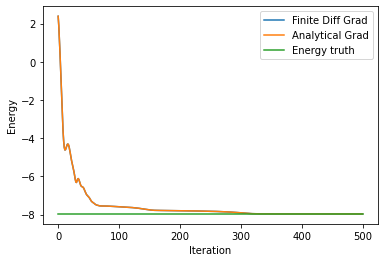

In [299]:
plt.plot(energy_list)
plt.plot(energy_list2)
plt.plot([0,499], [E_truth, E_truth])
plt.legend(["Finite Diff Grad", "Analytical Grad", "Energy truth"])
plt.xlabel("Iteration")
plt.ylabel("Energy")

In [71]:
n = 4
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

rbm = RBM(n_vis=n, n_hid=20, hamiltonian=hamiltonian)
energy_list = rbm.train(iter=500, lr=0.01)

Energy truth: -13.055371981671408


  0%|          | 0/500 [00:00<?, ?it/s]

-1.074847492362283
-1.2916746481174086
-1.4946576662156636
-1.8113586129699029
-2.431260467094769
-3.5876987245184946
-5.0926762350393515
-6.033681716374039
-6.12127586856422
-6.090957643430041
-6.27913378822666
-6.718736831828913
-7.288829797596382
-7.559186572213042
-7.15988831668645
-6.783059884137309
-6.8829006675953925
-7.29847392821612
-7.679225977232646
-7.780972208468991
-7.6918372297981
-7.615599441053968
-7.647951889045405
-7.790631939227115
-7.994020417219367
-8.17370502487488
-8.247088794376378
-8.210011746738296
-8.162082400013059
-8.206732353012939
-8.355680264297458
-8.537180295125262
-8.667998140679579
-8.724698703715672
-8.74614096106818
-8.776346077272589
-8.825294830229005
-8.87861101601484
-8.936063295518831
-9.023953422395907
-9.149796070042015
-9.279459457778307
-9.373792926206454
-9.426806811730435
-9.463888696031969
-9.512258778337177
-9.581708802190766
-9.668061578634422
-9.764225092302393
-9.863183395931312
-9.954959819748435
-10.030821872354625
-10.0933023023

Text(0, 0.5, 'Energy')

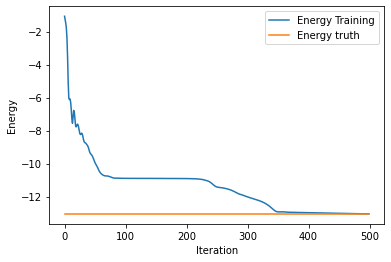

In [72]:
plt.plot(energy_list)
plt.plot([0,499], [E_truth, E_truth])
plt.legend(["Energy Training", "Energy truth"])
plt.xlabel("Iteration")
plt.ylabel("Energy")

In [302]:
n = 6
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

rbm = RBM(n_vis=n, n_hid=32, hamiltonian=hamiltonian)
energy_list = rbm.train(iter=1000, lr=0.01)

Energy truth: -30.111023244552147


  0%|          | 0/1000 [00:00<?, ?it/s]

0.5260510084454273
0.1881954389882139
-0.101169751166646
-0.39903348120913046
-0.7593197130296824
-1.2459569754771267
-1.9075404285690152
-2.6754914753616514
-3.285616600790342
-3.578351505673565
-3.7556693786930655
-4.016201833056256
-4.394587991847615
-4.770891785103451
-4.853038323873063
-4.694169195148909
-4.802107839431507
-5.110746716890121
-5.318018655117993
-5.345507851392965
-5.3644102454172735
-5.474850830976712
-5.62375816686679
-5.715896008320357
-5.787947881580396
-5.928303303294173
-6.090856436220241
-6.190355809106414
-6.236535455294797
-6.297690257275378
-6.40632445040222
-6.5473110877837275
-6.695341924999529
-6.851107520582948
-7.042218403421154
-7.295286309377764
-7.612861654016602
-7.940203062778848
-8.148102445813528
-8.224461838581849
-8.362972296255302
-8.51639315723644
-8.56186784328018
-8.57923796401758
-8.662103987739226
-8.772286031961658
-8.819737488448876
-8.827771184910947
-8.888147167797369
-8.983042364022918
-9.057455813490408
-9.12505136156226
-9.216719

Text(0, 0.5, 'Energy')

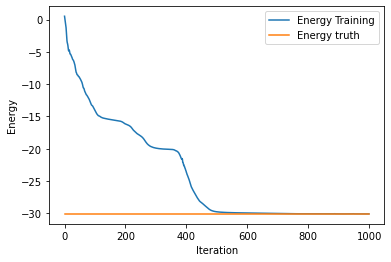

In [304]:
plt.plot(energy_list)
plt.plot([0,999], [E_truth, E_truth])
plt.legend(["Energy Training", "Energy truth"])
plt.xlabel("Iteration")
plt.ylabel("Energy")